## Akwizycja danych

Skrypt otwiera połączenie na wybranym interfejsie (tutaj COM4) i odbiera dane z sensorów.  
Następnie zapisuje dane do pliku .pkl, który może zostać przeanalizowany przez aplikację. Dane nie są tutaj w żaden sposób przetwarzane, więc aplikacja otrzymuje je w tkaim samym formacie, w jakim wysyłane są one przez mikrokontroler.

In [1]:
import json
import serial
import time
from datetime import datetime
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

DATA_ACQUISITION_TIME_S = 30 
SERIAL_INTERFACE = "COM4"

In [5]:
data = []
if DATA_ACQUISITION_TIME_S <= 0:
    # Reading data from file
    with open('data.json') as file:
        data = json.load(file)

else:
    # Reading data from Arduino serial
    try:
        com = serial.Serial(SERIAL_INTERFACE, 115200, timeout=1)
    except serial.SerialException:
        print("Serial connection on", SERIAL_INTERFACE, "cannot be opened")
        exit()

    time.sleep(1)
    print("Serial connection open")
    end_timestamp = datetime.now().timestamp() + DATA_ACQUISITION_TIME_S

    print("Reading data for", DATA_ACQUISITION_TIME_S, "seconds...")
    while end_timestamp - datetime.now().timestamp() > 0:
        try:
            line = com.readline()
            data.append(np.fromstring(line.decode("utf-8"), dtype=float, sep=" "))
        except UnicodeDecodeError:
            continue

    print("Serial connection closed")
    com.close()

Serial connection open
Reading data for 30 seconds...
Serial connection closed


In [7]:
data = np.array(data)
pd.to_pickle(data, "data.pkl")
data


array([[ 0.000e+00,  2.400e+01,  3.609e+01,  9.700e+01,  8.000e+01],
       [ 1.000e+00,  2.884e+01, -7.900e-01,  8.000e-02,  1.002e+01],
       [ 1.000e+00,  2.884e+01, -8.100e-01,  9.000e-02,  1.001e+01],
       ...,
       [ 1.000e+00,  2.888e+01, -8.400e-01,  1.600e-01,  1.002e+01],
       [ 1.000e+00,  2.880e+01, -8.500e-01,  1.300e-01,  9.990e+00],
       [ 1.000e+00,  2.893e+01, -8.500e-01,  1.000e-01,  9.960e+00]])

Dane przychodzą teraz w formacie:

```
0 lm35_temp max_temp max_spo2 max_bpm
1 ada_temp ada_x ada_y ada_z
1 ada_temp ada_x ada_y ada_z
1 ada_temp ada_x ada_y ada_z
1 ada_temp ada_x ada_y ada_z
...
```

Każda linia skąda się z 5 wartości numerycznych oddzielonych jedną spacją.  
Każda linia, gdzie pierwsza wartość to 0, przesyła wartości z termometru i pulsoksymetru  
Każda linia, gdzie pierwsza wartość to 1, przesyła wartości z akcelerometru  
Na jedną linię `0` przypada 200 linni `1`  
Dokładny format podany powyżej  

## Rozpakowanie danych

Poniżej umieszczone są operacje numpyowe do wydzielenia danych do osobnych tablic.  
Operacje te są wykonywane osobno w aplikacji po odczytaniu całego pliku z danymi - tutaj mają one charakter prezentacyjny  
  
Wartość -1 oznacza brak możliwości zmierzenia danych - jest ignorowana


In [8]:
max = data[data[:, 0] == 0.0]
ada = data[data[:, 0] == 1.0]

lm35_temp = max[:, 1]
max_temp = max[:, 2]
max_spo2 = max[:, 3]
max_bpm = max[:, 4]

ada_temp = ada[:, 1]
ada_x = ada[:, 2]
ada_y = ada[:, 3]
ada_z = ada[:, 4]

In [9]:
print("Temperatura LM35:", lm35_temp)
print("Temperatura MAX30102:", max_temp)
print("Natlenienie krwi:", max_spo2)
print("Tętno:", max_bpm)

Temperatura LM35: [24. 26. 27. 28. 24. 26. 28. 24. 29. 29.]
Temperatura MAX30102: [36.09 36.12 36.14 36.13 36.14 36.15 37.03 37.   36.14 36.15]
Natlenienie krwi: [97. 98. 96. 95. 95. 95. 95. 97. 98. -1.]
Tętno: [80. 84. 87. 85. 90. 99. 91. 96. -1. 91.]


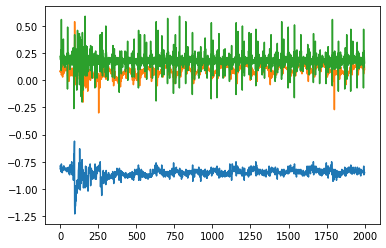

In [10]:
plt.plot(ada_x)
plt.plot(ada_y)
plt.plot(ada_z-9.8) # kompensacja przyspieszenia ziemskiego